In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
import config
importlib.reload(config)
from config import BIN_SIZE as bin_size
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group
from config import STRATIFY_BY as stratify

# 0. Check Config

In [61]:
print(analysis_mode)
print(specific_group)
print(bin_size)

all_vs_healthy
Bile Duct Cancer
50000


# 1. Loading of Dataframes

In [62]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")

if analysis_mode == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == specific_group) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()

if stratify =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
else:
    clinical_df = clinical_df
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


(115, 19)
(129, 19)
115
115
Number of Samples in Matrix: 230
Number of Bins per Sample: 4260.0


# 2. Pipeline for LASSO

In [63]:
C_values = np.logspace(-4, 4, 50)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for LASSO perfomance

In [64]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline, fast=True):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.base import clone
    import numpy as np

    pivot_df = df.pivot(index="sample", columns="bin_id", values=list(metrics))
    pivot_df.columns = [f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns]

    # lables and stratify
    y = []
    strata = []
    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        is_healthy = row["Patient Type"].lower() == "healthy"
        target_val = 0 if is_healthy else 1
        y.append(target_val)
        if stratify == "Gender":
            strata.append(row["Gender"])
        else:
            strata.append(target_val)

    y = np.array(y)
    X = pivot_df

    # Split in Training and Test (80/20)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=strata, random_state=42
    )

    if fast:
        # STAGE 1: fast screening
        # less c values 
        fast_lasso = LogisticRegressionCV(
            Cs=15, 
            cv=2, 
            penalty='l1', 
            solver='liblinear', 
            scoring='roc_auc', 
            max_iter=2000, 
            random_state=42
        )
        fast_pipeline = clone(pipeline)
        fast_pipeline.steps[-1] = ('lasso_cv', fast_lasso)
        
        fast_pipeline.fit(X_train_full, y_train_full)
        y_prob = fast_pipeline.predict_proba(X_test)[:, 1]
        return {"metrics": metrics, "roc_auc": roc_auc_score(y_test, y_prob)}
    
    # STAGE 2: full benchmarking for top 10 combinations

    print(f"  > Full benchmarking for {metrics}...", flush=True)
    
    # 1. 5-Fold Cross Validation for stability analysis
    cv_results = cross_validation(X_train_full, y_train_full, pipeline, n_folds=5)
    
    # 2. count stable features (features in all 5 folds selected)
    stability_df = analyze_feature_stability(cv_results)
    n_stable = len(stability_df[stability_df['Frequency'] == 5]) if not stability_df.empty else 0

    # 3. determine the 1SE (Parsimonious) C-value
    pipeline.fit(X_train_full, y_train_full)
    lasso_cv = pipeline.named_steps['lasso_cv']
    mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
    std_scores = np.std(lasso_cv.scores_[1], axis=0)
    sem_scores = std_scores / np.sqrt(5)
    
    best_idx = np.argmax(mean_scores)
    best_score = mean_scores[best_idx]
    threshold = best_score - sem_scores[best_idx]
    idx_1se = np.where(mean_scores >= threshold)[0][0]
    c_1se = float(lasso_cv.Cs_[idx_1se])

    # 4. fit simple model (1SE) to calculate the ratio
    stable_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('stable_model', LogisticRegression(
            penalty='l1', 
            solver='liblinear', 
            C=c_1se, 
            max_iter=10000, 
            random_state=42
        ))
    ])
    stable_pipeline.fit(X_train_full, y_train_full)

    # 5. extract metrics
    pars_features = np.sum(stable_pipeline.named_steps['stable_model'].coef_[0] != 0)
    pars_stability_ratio = (n_stable / pars_features) if pars_features > 0 else 0.0

    simple_features = np.sum(lasso_cv.coef_[0] != 0)
    simple_stability_ratio = (n_stable / simple_features) if simple_features > 0 else 0.0

    y_prob_test = pipeline.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob_test)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features_best": int(simple_features),
        "simple_features": int(simple_features),
        "simple_stability_ratio": simple_stability_ratio,
        "n_stable": n_stable,
        "pars_features": int(pars_features),
        "pars_stability_ratio": pars_stability_ratio,
        "cv_auc": np.mean([e['auc'] for e in cv_results]),
        "test_auc": test_auc,
        "best_C": lasso_cv.C_[0]
    }

# 4. Feature Selektion for LASSO (combinations of metrics)

In [65]:
### 2. Aktualisierter Loop: Zweistufen-Suche
# Erst schnelles Screening (Stage 1), dann Detail-Analyse der Top 10 (Stage 2).

df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
metrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]

print("STAGE 1: Fast Screening (all combinations)", flush=True)
results_fast = []

for r in range(1, len(metrics_to_test) + 1):
    for combination in itertools.combinations(metrics_to_test, r):
        print(f"Screening combo {combination}...", flush=True)
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline, fast=True)
        results_fast.append(res)
        print(f"  > Fast AUC: {res['roc_auc']:.3f}", flush=True)

# Auswahl der Top 7 nach AUC aus dem Screening
top_7 = pd.DataFrame(results_fast).sort_values("roc_auc", ascending=False).head(7)
print(f"\nTop 7 candidates found. Starting Stage 2 Deep Analysis...", flush=True)

print("\nSTAGE 2: Full Benchmarking Top 7", flush=True)
metrics_results = []
for idx, row in top_7.iterrows():
    combo = row['metrics']
    res = run_lasso_for_metrics(df, clinical_df, combo, pipeline, fast=False)
    metrics_results.append(res)

# Ergebnisse speichern und anzeigen
metrics_results = pd.DataFrame(metrics_results).sort_values("cv_auc", ascending=False)
metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/lasso_metrics_results_{bin_size}.csv", index=False)

print("\n--- FINAL RESULTS (Top 10) ---", flush=True)
display(metrics_results)

best_metrics = metrics_results.iloc[0]['metrics']
print("\n>>> SELECTED BEST METRICS:", best_metrics, flush=True)

STAGE 1: Fast Screening (all combinations)
Screening combo ('mean',)...
  > Fast AUC: 0.933
Screening combo ('median',)...
  > Fast AUC: 0.813
Screening combo ('stdev',)...
  > Fast AUC: 0.790
Screening combo ('wps_value',)...
  > Fast AUC: 0.796
Screening combo ('min',)...
  > Fast AUC: 0.547
Screening combo ('max',)...
  > Fast AUC: 0.644
Screening combo ('mean', 'median')...
  > Fast AUC: 0.926
Screening combo ('mean', 'stdev')...
  > Fast AUC: 0.840
Screening combo ('mean', 'wps_value')...
  > Fast AUC: 0.766
Screening combo ('mean', 'min')...
  > Fast AUC: 0.825
Screening combo ('mean', 'max')...
  > Fast AUC: 0.834
Screening combo ('median', 'stdev')...
  > Fast AUC: 0.846
Screening combo ('median', 'wps_value')...
  > Fast AUC: 0.701
Screening combo ('median', 'min')...
  > Fast AUC: 0.834
Screening combo ('median', 'max')...
  > Fast AUC: 0.762
Screening combo ('stdev', 'wps_value')...
  > Fast AUC: 0.670
Screening combo ('stdev', 'min')...
  > Fast AUC: 0.568
Screening combo (

,metrics,n_metrics,n_features,n_selected_features_best,simple_features,simple_stability_ratio,n_stable,pars_features,pars_stability_ratio,cv_auc,test_auc,best_C
6,"(mean, median, min, max)",4,17040,4642,4642,0.009694,45,4642,0.009694,0.786062,0.866667,6866.488450
2,"(mean, stdev, min, max)",4,17040,387,387,0.087855,34,91,0.373626,0.782066,0.817143,11.513954
4,"(median, stdev, min)",3,12780,4462,4462,0.001569,7,3629,0.001929,0.777160,0.857143,10000.000000
5,"(mean, median, stdev, min, max)",5,21300,5031,5031,0.006758,34,5031,0.006758,0.755393,0.864762,6866.488450
3,"(mean, median, stdev, min)",4,17040,4650,4650,0.006022,28,2369,0.011819,0.753964,0.868571,6866.488450
1,"(mean, median)",2,8520,4699,4699,0.100234,471,476,0.989496,0.748083,0.940952,10000.000000
0,"(mean,)",1,4260,2469,2469,0.222762,550,843,0.652432,0.746361,0.931429,6866.488450



>>> SELECTED BEST METRICS: ('mean', 'median', 'min', 'max')


In [77]:
filtered = metrics_results[
    (metrics_results['pars_stability_ratio'] >= 0.2)&
    (metrics_results['simple_stability_ratio'] >= 0.2)&
    (metrics_results['cv_auc'] >= 0.7)&
    (metrics_results['test_auc'] >= 0.7)
]
print(filtered)

   metrics  n_metrics  n_features  n_selected_features_best  simple_features  \
0  (mean,)          1        4260                      2469             2469   

   simple_stability_ratio  n_stable  pars_features  pars_stability_ratio  \
0                0.222762       550            843              0.652432   

     cv_auc  test_auc      best_C  
0  0.746361  0.931429  6866.48845  


# 5. Influence of metric selection on model performance

In [66]:
'''metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)'''#

'metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(\n    title="Mean ROC AUC vs Number of Metrics",\n    ylabel="ROC AUC",\n    xlabel="Number of Metrics"\n)'

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ('mean', 'median', 'min', 'max')


No NaNs in dataframe
lasso_cv.scores_[1]: [[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.58479532 0.67251462
  0.71637427 0.7748538  0.84210526 0.86842105 0.8625731  0.85964912
  0.84795322 0.85672515 0.84795322 0.85087719 0.84795322 0.85380117
  0.83040936 0.82748538 0.73391813 0.8128655  0.80701754 0.79532164
  0.80701754 0.76608187 0.75438596 0.78947368 0.73099415 0.78362573
  0.74853801 0.71345029 0.74853801 0.75438596 0.74853801 0.76608187
  0.8245614  0.73684211]
 [0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.60526316 0.71052632
  0.74269006 0.72807018 0.76023392 0.7748538  0.76900585 0.77777778
  0.78654971 0.7748538  0.76023392 0.76900585 0.75730994 0.73099415
  0.73976608 0.75146199 0.73684211 0.75146199 0.73099415 0.7251462
  0.728070

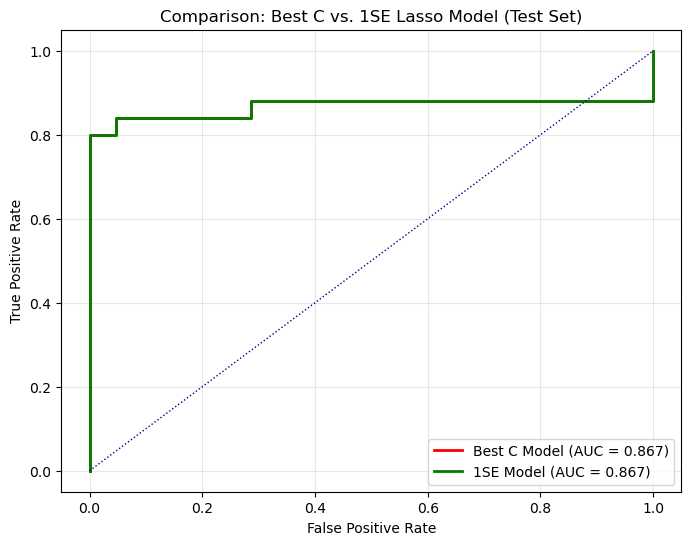

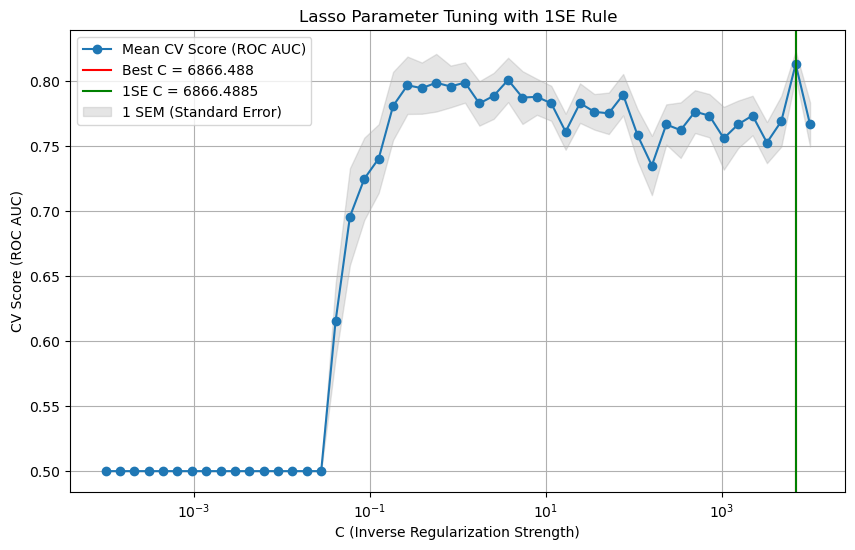

In [67]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    target_val = 0 if is_healthy else 1
    y.append(target_val)
    if stratify == "Gender":
        strata.append(row["Gender"])
    else:
        strata.append(target_val)

y = np.array(y)
X = pivot_df
n_nans = X.isna().sum().sum()
if n_nans > 0:
    print(f"{n_nans} NaNs found in dataframe")
else:
    print("No NaNs in dataframe")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)

# Fit
pipeline.fit(X_train, y_train)

lasso_cv = pipeline.named_steps["lasso_cv"]


# --- 1se Rule Calculation ---
# scores_[1] is of shape (n_folds, n_Cs)
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
print(f"lasso_cv.scores_[1]: {lasso_cv.scores_[1]}")
print(f"mean lasso scores: {mean_scores}")
std_scores = np.std(lasso_cv.scores_[1], axis=0)
n_folds = 5
sem_scores = std_scores / np.sqrt(n_folds)
cs = lasso_cv.Cs_

best_idx = np.argmax(mean_scores)
print(f"best_idx: {best_idx}")
best_c = float(cs[best_idx])
best_score = mean_scores[best_idx]
best_sem = sem_scores[best_idx]
threshold = best_score - best_sem

# c_1se: smallest C (most parsimonious) within 1 SEM of maximum
idx_1se = np.where(mean_scores >= threshold)[0][0]
c_1se = float(cs[idx_1se])

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---

stable_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=c_1se,
    max_iter=10000,
    random_state=42
)

stable_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', stable_lasso)
])



stable_pipeline.fit(X_train, y_train)
# 1. Calculate probabilities for both models (Test Set)
y_prob_best = pipeline.predict_proba(X_test)[:, 1]
y_prob_1se = stable_pipeline.predict_proba(X_test)[:, 1]

# 2. Calculate ROC values for both models
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
fpr_1se, tpr_1se, _ = roc_curve(y_test, y_prob_1se)

auc_best = roc_auc_score(y_test, y_prob_best)
auc_1se = roc_auc_score(y_test, y_prob_1se)

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se, tpr_1se, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/lasso_parameter_tuning{bin_size}.png")
plt.show()

## 5.2 Training vs. Test with best model 

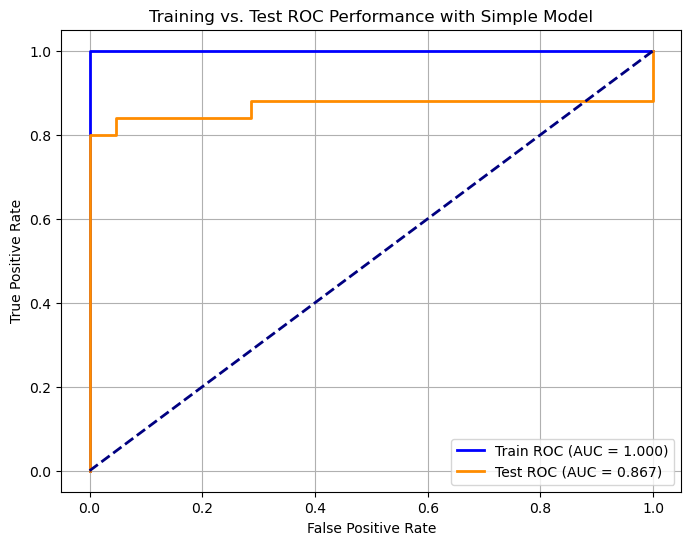

In [68]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.3 Training vs. Test with 1SE Model

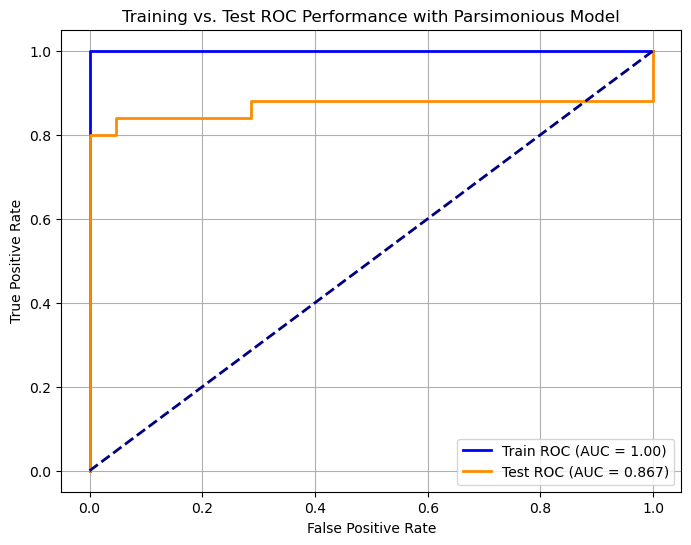

In [69]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Important Features


## 6.1 Pipeline with best model

                Feature  Coefficient
0     mean_chr10_100000     0.000000
1  mean_chr10_100950000     0.000000
2  mean_chr10_101050000     0.014103
3  mean_chr10_101400000     0.000000
4  mean_chr10_101550000    -0.039700
SINGLE MODEL (Best C)
Number of Important Features (Best Model): 4642

Top Features (Best Model - Positive = Indicative for Cancer):


<AxesSubplot:title={'center':'Top Features (Best Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

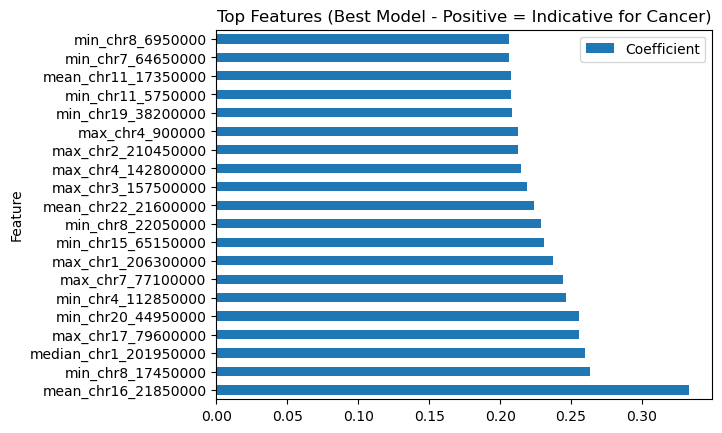

In [70]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Best Model): {len(important_features)}")
print("\nTop Features (Best Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Best Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 4642

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 4642 features selected
1SE Model:    4642 features selected
Difference:   0 fewer features in 1SE model


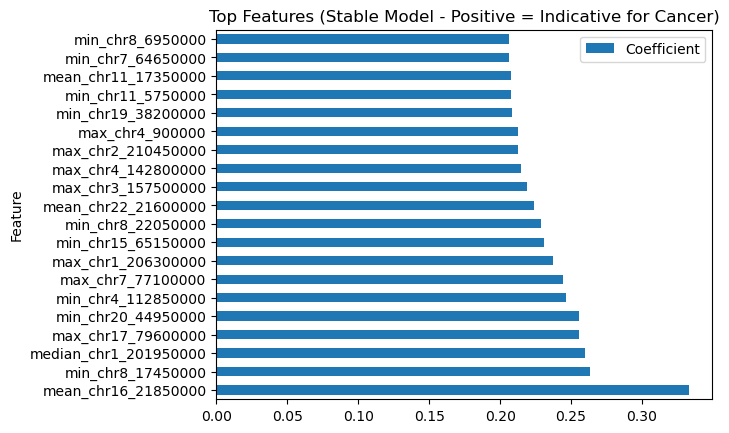

In [71]:

stable_lasso_model = stable_pipeline.named_steps['model']

stable_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": stable_lasso_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...


  AUC = 0.763, Best C = 232.99518105153672
Fold 2/5...
  AUC = 0.807, Best C = 0.3906939937054613
Fold 3/5...
  AUC = 0.675, Best C = 10000.0
Fold 4/5...
  AUC = 0.898, Best C = 6866.488450042998
Fold 5/5...
  AUC = 0.787, Best C = 2222.996482526191


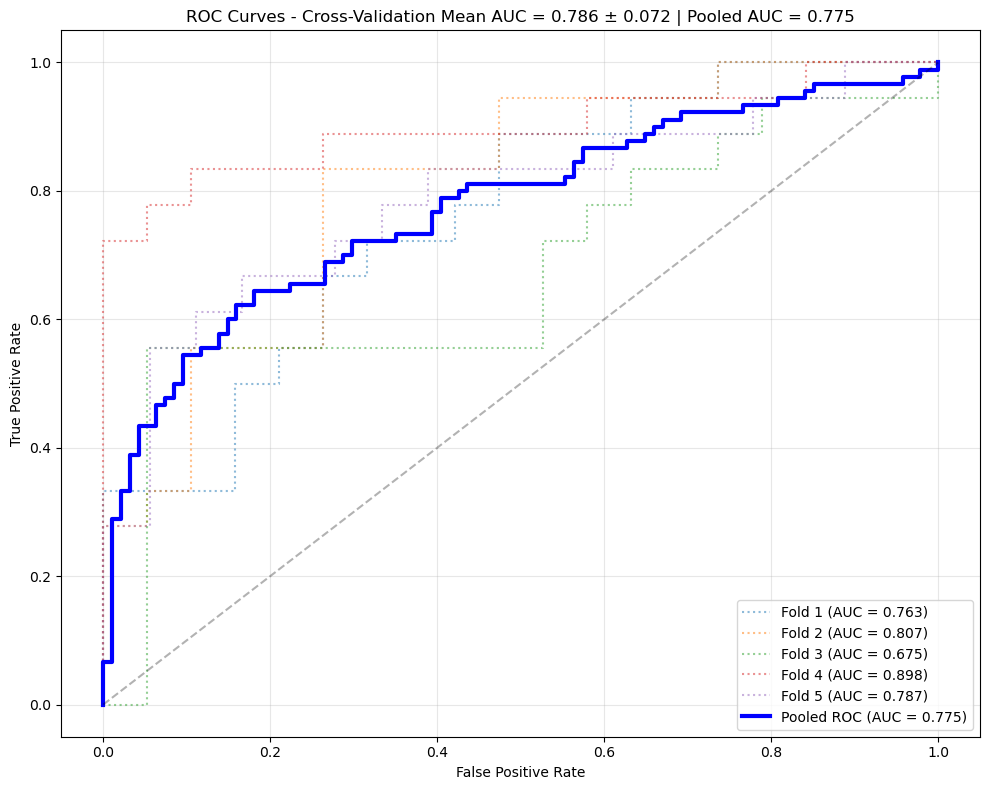

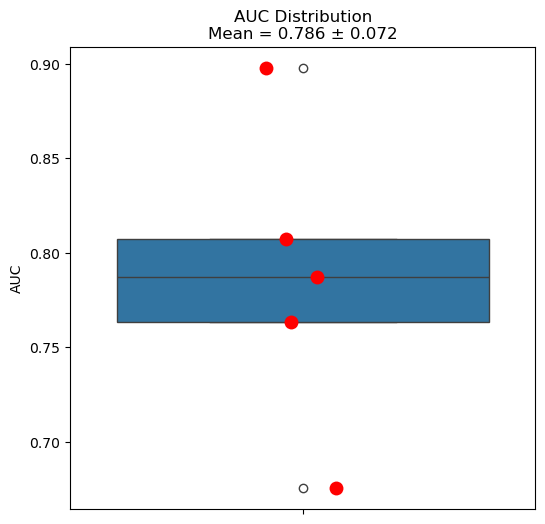

In [72]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves
print("Running 5-Fold Cross-Validation for Feature Stability.")

# X and y should be available from previous cells. 
# We use X (full pivot_df before split if available, or regenerate if needed).
# Assuming X and y are the full datasets as defined before train_test_split.

# Re-verify label consistency
# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, pipeline, n_folds=5)

# Plotte Performance
plot_roc_curves(cv_results)
plot_auc_boxplot(cv_results)


## 7.2 Table with Statistical Values

In [73]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision  \
0     1  0.763158  0.675676     0.666667     0.684211   0.666667   
1     2  0.807018  0.729730     0.722222     0.736842   0.722222   
2     3  0.675439  0.540541     0.555556     0.526316   0.526316   
3     4  0.897661  0.837838     0.833333     0.842105   0.833333   
4     5  0.787037  0.722222     0.666667     0.777778   0.750000   
5  Mean  0.786062  0.701201     0.688889     0.713450   0.699708   
6   Std  0.080088  0.107690     0.100922     0.119490   0.114071   

         Best_C   N_Features  
0    232.995181  2097.000000  
1      0.390694    82.000000  
2  10000.000000  4578.000000  
3   6866.488450  3716.000000  
4   2222.996483  1758.000000  
5   3864.574162  2446.200000  
6   4400.852095  1756.556632  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                 Feature  Frequency  Frequency_Percent  Mean_Coef
2027   max_chr7_77100000          5              100.0   0.234792
979   min_chr19_38200000          5              100.0   0.223913
1693  max_chr1_149600000          5              100.0   0.201902
1253     min_chr5_150000          5              100.0   0.193130
1451  max_chr11_45800000          5              100.0   0.189575


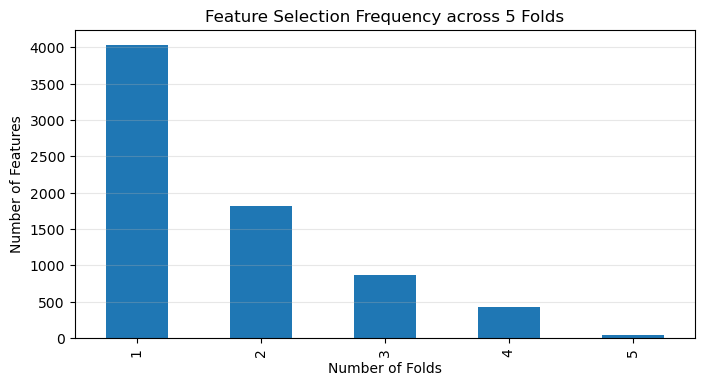

Features in ALL 5 folds: 45


In [74]:
stability_df = analyze_feature_stability(cv_results)
n_folds = 5
stable_in_all = stability_df[stability_df['Frequency'] == n_folds]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))


plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}_fold.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

## 7.4 Feature Overlap Heatmap 


Text(0.5, 1.0, 'Feature Selection Consistency')

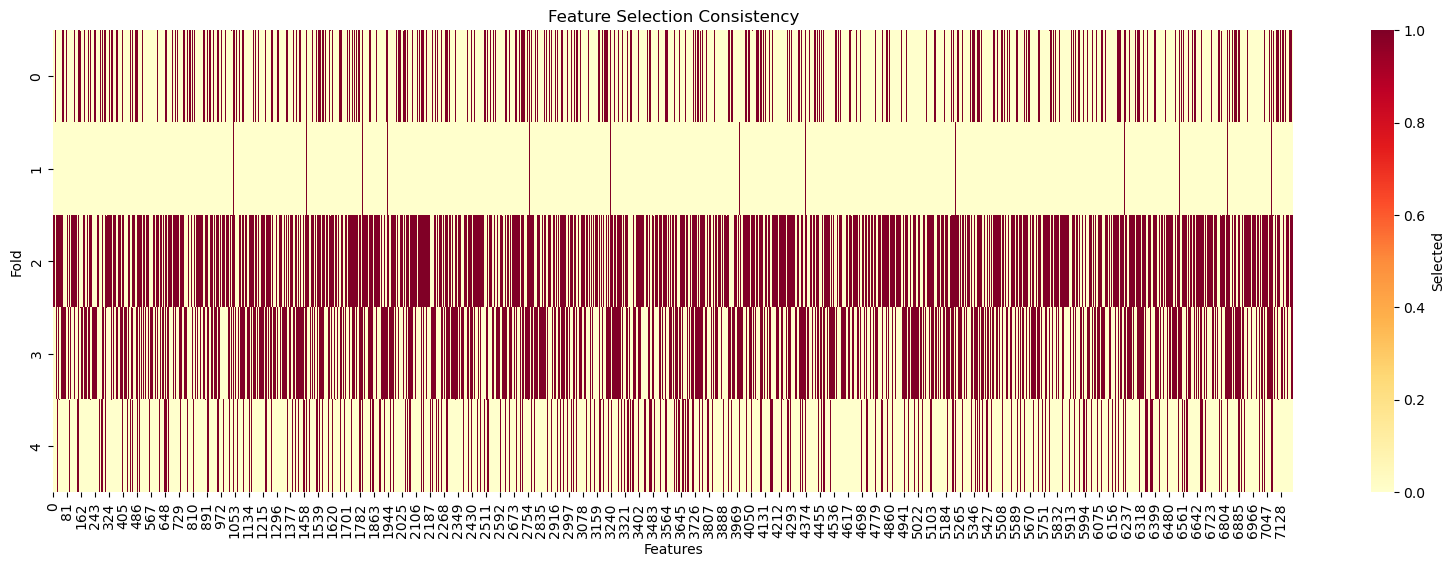

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

n_folds = len(cv_results)
all_features = set()
for e in cv_results:
    all_features.update(e['selected_features'].keys())

matrix = np.zeros((n_folds, len(all_features)))
for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

plt.figure(figsize=(20, 6))
sns.heatmap(matrix, cmap='YlOrRd', cbar_kws={'label': 'Selected'})
plt.xlabel('Features')
plt.ylabel('Fold')
plt.title('Feature Selection Consistency')

## 7.5 Saving stable features in file for comparison

In [76]:
import pandas as pd
from itertools import combinations

def extract_genomic_position(feature):
    if 'chr' in feature:
        return feature[feature.index('chr'):]
    return feature

metrics = {
    "mean": "stable_features_['mean']_50000_fold.csv",
    "stdev": "stable_features_['stdev']_50000_fold.csv",
    "wps": "stable_features_['wps_value']_50000_fold.csv",
    "mean_median_stdev": "stable_features_['mean', 'median', 'stdev']_50000_fold.csv"
}

base_path = "/labmed/workspace/lotta/finaletoolkit/outputs/statistics/"

feature_sets = {}

for metric, file in metrics.items():
    df = pd.read_csv(base_path + file)
    cleaned = {get_position(f) for f in df['Feature']}
    feature_sets[metric] = cleaned


for (m1, f1), (m2, f2) in combinations(feature_sets.items(), 2):
    intersection = f1 & f2
    print(
        f"Intersection between {m1} and {m2}: "
        f"{len(intersection)} stable features\n{intersection}\n"
    )


NameError: name 'get_position' is not defined

# 8. Visualize the ROC Calculation (Label, Probability)

In [ ]:
# 1. Get the probabilities for the test set 
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE87908           1            0.954932
1   EE87901           1            0.856143
2   EE87912           1            0.580510
3   EE88025           0            0.371873
4   EE87909           1            0.355136


In [ ]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


No outliers found.
